In [1]:
from functools import partial
import sys
# sys.path.append('../src')
import KBio
import numpy as np
import matplotlib.pyplot as plt

import math


In [2]:
# p = KBio.Polynomial(degree = 3, c=0.1)
p = KBio.Gaussian(sigma=1e-2)

In [3]:
np.random.seed(7)

In [4]:

# Define parameters for the 1D Advection simulation
dt = 0.01
nx = 500

T_final = 1  # Final time
tsteps = math.ceil(T_final / dt)  # Number of time steps


# u0 = np.sin(np.linspace(0, 2 * np.pi, nx))  # Initial condition on [0,1]

def u0(x):
    return 1 + np.sin(8 * np.pi * x)

def ux(x):
    return 2 + np.sin(12 * np.pi * x)

# Color equation parameterization
c = 1
def ux_const(x, c=c):
    return c

# Forcing function psi

def psi(q,x):
    # return 0
    return (x ** 2 - 0.25) / 20

# Create a rectangular grid for the simulation
# time, then x.
# u[i, :] is the solution at time i
grid = KBio.rectangular_grid(mins=np.array([0, 0]), maxes=[T_final, 1], n_pts=[tsteps+1, nx])

# Create an instance of the Advection1D class
advection_sim = KBio.Advection1D_sim(dt, u0=u0, T_final=T_final, forcing = lambda t, x: 0, nx=nx, ux=ux_const)

# Run the simulation
t_, x_, u_, ffun, ufun = advection_sim(grid, forcing=psi, pyvis=False)


2024-05-31 17:06:45,415 INFO CLAW: Solution 0 computed for time t=0.000000
2024-05-31 17:06:45,418 INFO CLAW: Solution 1 computed for time t=0.010000
2024-05-31 17:06:45,420 INFO CLAW: Solution 2 computed for time t=0.020000
2024-05-31 17:06:45,422 INFO CLAW: Solution 3 computed for time t=0.030000
2024-05-31 17:06:45,424 INFO CLAW: Solution 4 computed for time t=0.040000
2024-05-31 17:06:45,426 INFO CLAW: Solution 5 computed for time t=0.050000
2024-05-31 17:06:45,428 INFO CLAW: Solution 6 computed for time t=0.060000
2024-05-31 17:06:45,430 INFO CLAW: Solution 7 computed for time t=0.070000
2024-05-31 17:06:45,432 INFO CLAW: Solution 8 computed for time t=0.080000
2024-05-31 17:06:45,435 INFO CLAW: Solution 9 computed for time t=0.090000
2024-05-31 17:06:45,437 INFO CLAW: Solution 10 computed for time t=0.100000
2024-05-31 17:06:45,439 INFO CLAW: Solution 11 computed for time t=0.110000
2024-05-31 17:06:45,441 INFO CLAW: Solution 12 computed for time t=0.120000
2024-05-31 17:06:45,44

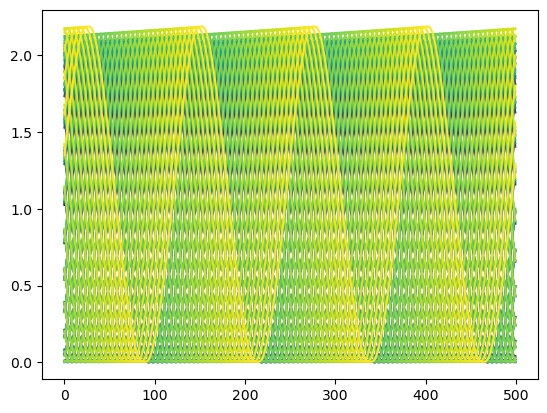

In [5]:
colors = plt.cm.viridis(np.linspace(0, 1, tsteps))
for t in range(tsteps):
    # print(t)
    plt.plot(grid.grid_tensors_values[t, :], color=colors[t])

In [6]:
# A simple forcing function to consider

def psi_simple(q,x, b):
    return b * x

In [12]:
n_train = 3

dt = 0.02
nx = 6
T_final = 0.1  # Final time
tsteps = math.ceil(T_final / dt)  # Number of time steps

speed_c_values = np.random.normal(2, 0.2, n_train)
forcing_b_values = np.random.normal(0, 0.5, n_train)
x_max = 0.5

def u0(x):
    return 1 + np.sin(8 * np.pi * x)

def ux(x):
    return 2 + np.sin(12 * np.pi * x)

sim = KBio.Advection1D_sim(dt, u0=u0, T_final=T_final, forcing = lambda t, x: 0, nx=nx, ux=ux)

forcings = [partial(psi_simple, b=b) for b in forcing_b_values]

grid_train = [KBio.rectangular_grid(mins=np.array([0, 0]), maxes=[T_final, 1], n_pts=[tsteps+1, nx]) for _ in range(n_train)]
for grid, fn in zip(grid_train, forcings):
    sim(grid, forcing = fn)

2024-05-31 17:08:36,482 INFO CLAW: Solution 0 computed for time t=0.000000
2024-05-31 17:08:36,484 INFO CLAW: Solution 1 computed for time t=0.020000
2024-05-31 17:08:36,485 INFO CLAW: Solution 2 computed for time t=0.040000
2024-05-31 17:08:36,486 INFO CLAW: Solution 3 computed for time t=0.060000
2024-05-31 17:08:36,487 INFO CLAW: Solution 4 computed for time t=0.080000
2024-05-31 17:08:36,488 INFO CLAW: Solution 5 computed for time t=0.100000
(6,)
(6, 6)
2024-05-31 17:08:36,492 INFO CLAW: Solution 0 computed for time t=0.000000
2024-05-31 17:08:36,493 INFO CLAW: Solution 1 computed for time t=0.020000
2024-05-31 17:08:36,495 INFO CLAW: Solution 2 computed for time t=0.040000
2024-05-31 17:08:36,496 INFO CLAW: Solution 3 computed for time t=0.060000
2024-05-31 17:08:36,497 INFO CLAW: Solution 4 computed for time t=0.080000
2024-05-31 17:08:36,498 INFO CLAW: Solution 5 computed for time t=0.100000
(6,)
(6, 6)
2024-05-31 17:08:36,502 INFO CLAW: Solution 0 computed for time t=0.000000
2

## Now we calculate derivatives

In [13]:
x_data = np.asarray([grid.grid_list for grid in grid_train])
x_m = np.mean(x_data, axis=1)

In [14]:
x_m

array([[0.05, 0.5 ],
       [0.05, 0.5 ],
       [0.05, 0.5 ]])

In [15]:
x_data.shape

(3, 36, 2)

In [20]:
# Reformat the data into a format that can be used by the Kernel
smoothed_data = []
smoothed_derivatives = []
alphas_list = [[0,0], [0,1], [1,0]]
x_data = np.asarray([grid.grid_list for grid in grid_train])
# standardize x_data to mean 0 variance 1
x_mean = np.mean(np.asarray(x_data), axis=1)  # take over middle "points" axis
x_std = np.std(np.asarray(x_data), axis=1)
x_data = (x_data - x_mean[0,:]) / x_std[0,:]

y_data = np.stack([grid.grid_tensors_values for grid in grid_train])
y_data = y_data.reshape((n_train, -1))
# y_data += np.random.normal(0, 1e-3, y_data.shape)
f_data = np.stack([grid.grid_tensors_forcing for grid in grid_train])

z, kdList, u_smoothed = KBio.kernel_smoothing(p, x_grid = x_data, u_data = y_data, f_data = f_data, alpha_list=alphas_list, nugget=1e-8)
# u_smoothed

n_grid_pts:  36


ValueError: shapes (72,72) and (36,3) not aligned: 72 (dim 1) != 36 (dim 0)

In [17]:
y_data.shape

(3, 36)

In [ ]:
f_data.shape

(3, 26, 101)